In [108]:
import os
import pandas as pd

def read_all_csvs(main_path, dataset_names, classifier_names, algorithm_names, date):
    dfs_fairness = []
    dfs_performance = []
    
    for dataset_name in dataset_names:
        df_data_fair = []
        df_data_perf = []
        for classifier_name in classifier_names:
            for algorithm_name in algorithm_names:
                folder_path = os.path.join(main_path, f'{algorithm_name}_{dataset_name}_{classifier_name}/heom')
                folders_inside_folder = os.listdir(folder_path)
                for folder_name in folders_inside_folder:
                    for i in range(0, 5):
                        if os.path.exists(os.path.join(folder_path, folder_name, date, f'fairness_{i}.csv')):
                            fair_path = os.path.join(folder_path, folder_name, date, f'fairness_{i}.csv')
                            perf_path = os.path.join(folder_path, folder_name, date, f'performance_{i}.csv')
                            df_fair = pd.read_csv(fair_path)
                            df_performance = pd.read_csv(perf_path)
                            df_fair['classifier'] = [classifier_name] * len(df_fair)
                            df_fair['algorithm'] = [algorithm_name if 'fair' in x else '-' for x in df_fair['data']]
                            df_fair['iteration'] = [i] * len(df_fair)
                            df_fair['params'] = [folder_name if 'fair' in x else '-' for x in df_fair['data']]
                            # df_fair.drop(columns=['data', 'average_odds', 'average_absolute_odds'], inplace=True)
                            df_fair.drop(columns=['data'], inplace=True)
                            df_performance['classifier'] = [classifier_name] * len(df_performance)
                            df_performance['algorithm'] = [algorithm_name if 'fair' in x else '-' for x in df_performance['data']]
                            df_performance['iteration'] = [i] * len(df_performance)
                            df_performance['params'] = [folder_name if 'fair' in x else '-' for x in df_performance['data']]
                            df_performance.drop(columns=['data'], inplace=True)
                            df_data_fair.append(df_fair)
                            df_data_perf.append(df_performance)
        dfs_fairness.append(df_data_fair)
        dfs_performance.append(df_data_perf)
    return dfs_fairness, dfs_performance

In [109]:
def aggregate_runs(dfs):
    df = pd.concat(dfs).reset_index(drop=True)
    df.drop(columns=['iteration'], inplace=True)
    df_num_cols = [c for c in df.columns if c not in ['classifier', 'algorithm', 'params']]
    df.loc[:, df_num_cols] = df.loc[:, df_num_cols].abs()
    df = df.groupby(['classifier', 'algorithm', 'params']).agg(['mean', 'std'])
    return df

In [110]:
def aggregate_everything(dfs):
    df = pd.concat(dfs).reset_index(drop=True)
    df.drop(columns=['iteration', 'classifier', 'algorithm'], inplace=True)
    df_num_cols = [c for c in df.columns if c not in ['params']]
    df.loc[:, df_num_cols] = df.loc[:, df_num_cols].abs()
    df = df.groupby(['params']).agg(['mean', 'std'])
    return df

In [111]:
from matplotlib import pyplot as plt
import seaborn as sns

def aggregate_runs_no_mean(dfs, y):
    df = pd.concat(dfs).reset_index(drop=True)
    df_num_cols = [c for c in df.columns if c not in ['classifier', 'algorithm', 'params']]
    #df.loc[:, df_num_cols] = df.loc[:, df_num_cols].abs()
    g = sns.FacetGrid(df, col="classifier")
    g.map_dataframe(sns.lineplot, x='iteration', y=y, hue='params', errorbar=None)
    g.add_legend()
    plt.show()

In [116]:
main_path = '../validation'
dataset_names = ['adult', 'heart_disease', 'bank', 'german']
classifier_names = ['logistic_regression', 'mlp', 'decision_tree']
algorithm_names = ['hfos']
date = '2024-06-12'

dfs_fairness, dfs_performance = read_all_csvs(main_path, dataset_names, classifier_names, algorithm_names, date)

In [117]:
df_sums = []
for dataset_name, dfs_f, dfs_p in zip(dataset_names, dfs_fairness, dfs_performance):
    df_f = aggregate_everything(dfs_f)
    df_p = aggregate_everything(dfs_p)
    print(dataset_name)
    display(df_f)
    display(df_p)
    df_sum = ((1 - df_f[('average_absolute_odds', 'mean')].abs()) * df_p[('gmean', 'mean')]) ** 0.5
    df_sums.append(df_sum)
    print(df_sum)
    print('----------------------------------------------------------------')
print(pd.concat(df_sums, axis=1).agg(['mean'], axis=1))

adult


statistical_parity            accuracy           equal_opportunity  \
                     mean       std      mean       std              mean   
params                                                                      
-                0.180395  0.041744  0.105661  0.036315          0.211767   
11               0.160420  0.046543  0.059423  0.027880          0.107661   
3                0.167650  0.055993  0.077507  0.033910          0.112725   
5                0.169824  0.046139  0.068802  0.038400          0.114852   
7                0.166992  0.044831  0.062922  0.033082          0.110085   

                 average_odds           average_absolute_odds            \
             std         mean       std                  mean       std   
params                                                                    
-       0.134384     0.136677  0.066977              0.145071  0.062720   
11      0.098719     0.066798  0.051675              0.084364  0.046673   
3       0.078787     0.069086  0.039527              0.094696  0.030941   
5       0.107142     0.076818  0.051453              0.094295  0.045724   
7       0.083234     0.073897  0.042788              0.087900  0.034171   

       disparate_impact           adapted_disparate_impact            \
                   mean       std                     mean       std   
params                                                                 
-              0.328613  0.150454                 0.328613  0.150454   
11             0.588258  0.107145                 0.588258  0.107145   
3              0.575248  0.121129                 0.575248  0.121129   
5              0.566726  0.107142                 0.566726  0.107142   
7              0.566905  0.105453                 0.566905  0.105453   

           gmean            
            mean       std  
params                      
-       0.135252  0.086908  
11      0.068831  0.050259  
3       0.073998  0.044825  
5       0.069111  0.068098  
7       0.060134  0.047542

accuracy           balanced_accuracy                  f1            \
            mean       std              mean       std      mean       std   
params                                                                       
-       0.830370  0.024421          0.746087  0.044900  0.621243  0.073432   
11      0.794074  0.030140          0.783130  0.051586  0.640297  0.061832   
3       0.795111  0.017319          0.784829  0.039115  0.642289  0.042077   
5       0.794074  0.025665          0.782892  0.046783  0.640182  0.055292   
7       0.797630  0.025455          0.784635  0.046119  0.643597  0.054623   

           gmean            
            mean       std  
params                      
-       0.724286  0.063212  
11      0.780486  0.054488  
3       0.782215  0.041661  
5       0.780582  0.049450  
7       0.781977  0.049230

params
-     0.786901
11    0.845365
3     0.841512
5     0.840819
7     0.844536
dtype: float64
----------------------------------------------------------------
heart_disease


statistical_parity            accuracy           equal_opportunity  \
                     mean       std      mean       std              mean   
params                                                                      
-                0.257190  0.091523  0.106645  0.049938          0.136667   
11               0.177342  0.109972  0.070153  0.060307          0.136667   
3                0.166449  0.126244  0.075163  0.051608          0.176667   
5                0.164379  0.116652  0.068954  0.048264          0.150000   
7                0.171786  0.114677  0.073965  0.053934          0.150000   

                 average_odds           average_absolute_odds            \
             std         mean       std                  mean       std   
params                                                                    
-       0.118560     0.122415  0.059742              0.143120  0.063693   
11      0.085496     0.100310  0.072824              0.128750  0.058556   
3       0.099762     0.134765  0.068344              0.152436  0.059667   
5       0.090633     0.119989  0.075172              0.133494  0.062957   
7       0.086603     0.113226  0.066790              0.133333  0.055250   

       disparate_impact           adapted_disparate_impact            \
                   mean       std                     mean       std   
params                                                                 
-              0.497159  0.165010                 0.497159  0.165010   
11             0.697211  0.252831                 0.667685  0.205667   
3              0.738416  0.296115                 0.689401  0.237675   
5              0.740337  0.283483                 0.689183  0.218710   
7              0.714644  0.267420                 0.677492  0.213911   

           gmean            
            mean       std  
params                      
-       0.105735  0.080534  
11      0.068852  0.059266  
3       0.074737  0.056631  
5       0.062668  0.046560  
7       0.072526  0.053340

accuracy           balanced_accuracy                  f1            \
            mean       std              mean       std      mean       std   
params                                                                       
-       0.775285  0.066981          0.770725  0.068674  0.740469  0.084066   
11      0.764058  0.077057          0.763574  0.077463  0.745026  0.083038   
3       0.770370  0.068364          0.770264  0.067787  0.753560  0.070417   
5       0.762870  0.078002          0.761771  0.079296  0.740583  0.087108   
7       0.760377  0.075631          0.759472  0.076039  0.739388  0.081879   

           gmean            
            mean       std  
params                      
-       0.763749  0.073463  
11      0.759707  0.077287  
3       0.766736  0.068360  
5       0.758038  0.078993  
7       0.755702  0.076214

params
-     0.808975
11    0.813569
3     0.806137
5     0.810459
7     0.809285
dtype: float64
----------------------------------------------------------------
bank


statistical_parity            accuracy           equal_opportunity  \
                     mean       std      mean       std              mean   
params                                                                      
-                0.061970  0.046054  0.090324  0.056779          0.196435   
11               0.121066  0.108414  0.090995  0.046864          0.302633   
3                0.114101  0.097226  0.098025  0.070615          0.242159   
5                0.105501  0.099873  0.088801  0.062587          0.220569   
7                0.104522  0.116693  0.095673  0.055920          0.275532   

                 average_odds           average_absolute_odds            \
             std         mean       std                  mean       std   
params                                                                    
-       0.089265     0.108776  0.051080              0.118447  0.053978   
11      0.138296     0.186568  0.085833              0.194128  0.075329   
3       0.127957     0.137897  0.092450              0.175727  0.077294   
5       0.127098     0.130356  0.095448              0.154974  0.085973   
7       0.150646     0.161273  0.095080              0.184005  0.095960   

       disparate_impact           adapted_disparate_impact            \
                   mean       std                     mean       std   
params                                                                 
-              0.533440  0.160772                 0.533440  0.160772   
11             1.035758  0.574886                 0.651067  0.204782   
3              0.933869  0.451481                 0.667042  0.154016   
5              0.963763  0.443739                 0.690261  0.156502   
7              0.912607  0.399933                 0.726616  0.196973   

           gmean            
            mean       std  
params                      
-       0.298441  0.206600  
11      0.184490  0.187006  
3       0.158950  0.192476  
5       0.154357  0.172735  
7       0.150109  0.161082

accuracy           balanced_accuracy                  f1            \
            mean       std              mean       std      mean       std   
params                                                                       
-       0.882003  0.022591          0.615889  0.045356  0.333316  0.110739   
11      0.804985  0.022195          0.728163  0.067273  0.418584  0.058560   
3       0.812525  0.026431          0.730551  0.062353  0.427702  0.053038   
5       0.811129  0.023357          0.726992  0.069130  0.421768  0.063674   
7       0.808590  0.023703          0.726181  0.066731  0.419295  0.058261   

           gmean            
            mean       std  
params                      
-       0.484780  0.149370  
11      0.711324  0.090950  
3       0.713313  0.085819  
5       0.708188  0.095364  
7       0.707949  0.091896

params
-     0.653727
11    0.757123
3     0.766789
5     0.773587
7     0.760055
dtype: float64
----------------------------------------------------------------
german


statistical_parity            accuracy           equal_opportunity  \
                     mean       std      mean       std              mean   
params                                                                      
-                0.079278  0.058409  0.076048  0.041965          0.073067   
11               0.083757  0.059068  0.064408  0.054686          0.094607   
3                0.085377  0.070623  0.071408  0.050961          0.100954   
5                0.114827  0.118794  0.078836  0.082637          0.131694   
7                0.107305  0.064788  0.068466  0.056146          0.115027   

                 average_odds           average_absolute_odds            \
             std         mean       std                  mean       std   
params                                                                    
-       0.055788     0.085915  0.055052              0.100795  0.061889   
11      0.072850     0.057955  0.052411              0.081049  0.053900   
3       0.076594     0.063768  0.061221              0.095017  0.047907   
5       0.141432     0.089207  0.110562              0.112713  0.102211   
7       0.074087     0.087385  0.059936              0.107412  0.050620   

       disparate_impact           adapted_disparate_impact            \
                   mean       std                     mean       std   
params                                                                 
-              0.911623  0.071292                 0.907563  0.065827   
11             0.887701  0.115899                 0.869404  0.091863   
3              0.893511  0.129876                 0.870696  0.104411   
5              0.866509  0.193687                 0.831154  0.160459   
7              0.877841  0.153123                 0.835077  0.099294   

           gmean            
            mean       std  
params                      
-       0.153863  0.153165  
11      0.053749  0.052132  
3       0.063824  0.049809  
5       0.065929  0.056070  
7       0.067366  0.051206

accuracy           balanced_accuracy                  f1            \
            mean       std              mean       std      mean       std   
params                                                                       
-       0.708889  0.025288          0.593474  0.062168  0.807921  0.024278   
11      0.675185  0.031488          0.655467  0.037669  0.751369  0.031267   
3       0.682963  0.034533          0.660317  0.034312  0.758684  0.034589   
5       0.674074  0.044921          0.652205  0.051187  0.751233  0.039812   
7       0.677407  0.035103          0.660229  0.035146  0.751837  0.036481   

           gmean            
            mean       std  
params                      
-       0.451233  0.224307  
11      0.649665  0.043595  
3       0.653944  0.040303  
5       0.646101  0.055409  
7       0.654888  0.040820

params
-     0.636986
11    0.772665
3     0.769291
5     0.757151
7     0.764555
dtype: float64
----------------------------------------------------------------
            mean
params          
-       0.721647
11      0.797180
3       0.795932
5       0.795504
7       0.794608


In [50]:
for dataset_name, dfs in zip(dataset_names, dfs_performance):
    df = aggregate_everything(dfs)
    print(dataset_name)
    display(df)
    print('----------------------------------------------------------------')

adult


accuracy           balanced_accuracy                  f1  \
                   mean       std              mean       std      mean   
params                                                                    
-              0.833185  0.025969          0.740229  0.048775  0.615681   
custom_0.05_1  0.813185  0.037903          0.792420  0.040488  0.662530   
heom_0.05_1    0.800444  0.047187          0.777773  0.044970  0.643497   
hvdm_0.05_1    0.812296  0.036668          0.742423  0.055436  0.607809   

                            gmean            
                    std      mean       std  
params                                       
-              0.080129  0.714677  0.066324  
custom_0.05_1  0.056003  0.790286  0.041960  
heom_0.05_1    0.064114  0.775755  0.045725  
hvdm_0.05_1    0.082699  0.726058  0.069506

----------------------------------------------------------------
heart_disease


accuracy           balanced_accuracy                  f1  \
                   mean       std              mean       std      mean   
params                                                                    
-              0.803960  0.053028          0.799755  0.056475  0.772188   
custom_0.05_1  0.794083  0.059330          0.790475  0.063947  0.761828   
heom_0.05_1    0.776450  0.063997          0.775516  0.065614  0.756731   
hvdm_0.05_1    0.783974  0.052043          0.781952  0.054593  0.756789   

                            gmean            
                    std      mean       std  
params                                       
-              0.076317  0.792776  0.063436  
custom_0.05_1  0.089351  0.783947  0.073117  
heom_0.05_1    0.073692  0.771759  0.066847  
hvdm_0.05_1    0.070722  0.776183  0.059949

----------------------------------------------------------------
bank


accuracy           balanced_accuracy                  f1  \
                   mean       std              mean       std      mean   
params                                                                    
-              0.892328  0.010109          0.607834  0.050770  0.319827   
custom_0.05_1  0.784665  0.039618          0.747536  0.033923  0.431340   
heom_0.05_1    0.791054  0.056115          0.745287  0.029738  0.436177   
hvdm_0.05_1    0.806542  0.046080          0.683304  0.078200  0.377448   

                            gmean            
                    std      mean       std  
params                                       
-              0.141038  0.444347  0.186376  
custom_0.05_1  0.043324  0.744286  0.035823  
heom_0.05_1    0.043428  0.738980  0.034681  
hvdm_0.05_1    0.090877  0.648002  0.117156

----------------------------------------------------------------
german


accuracy           balanced_accuracy                  f1  \
                   mean       std              mean       std      mean   
params                                                                    
-              0.715185  0.026942          0.582804  0.061262  0.817823   
custom_0.05_1  0.594444  0.049020          0.549471  0.038938  0.693128   
heom_0.05_1    0.567778  0.049876          0.531834  0.038430  0.665534   
hvdm_0.05_1    0.598519  0.069784          0.550617  0.042176  0.694195   

                            gmean            
                    std      mean       std  
params                                       
-              0.015767  0.423928  0.210560  
custom_0.05_1  0.052247  0.532518  0.045736  
heom_0.05_1    0.054735  0.519404  0.040880  
hvdm_0.05_1    0.078706  0.525732  0.046191

----------------------------------------------------------------


In [41]:
for dataset_name, dfs in zip(dataset_names, dfs_fairness):
    df = aggregate_runs(dfs)
    print(dataset_name)
    display(df)
    print('----------------------------------------------------------------')

adult


statistical_parity            \
                                                          mean       std   
classifier          algorithm params                                       
decision_tree       -         -                       0.215511  0.036810   
                    FairRBO   custom_0.05_1           0.175990  0.074653   
                              heom_0.05_1             0.172072  0.088066   
                              hvdm_0.05_1             0.101123  0.037892   
logistic_regression -         -                       0.198057  0.044127   
                    FairRBO   custom_0.05_1           0.241022  0.050629   
                              heom_0.05_1             0.213283  0.044571   
                              hvdm_0.05_1             0.198504  0.061462   
mlp                 -         -                       0.180862  0.023327   
                    FairRBO   custom_0.05_1           0.205264  0.037205   
                              heom_0.05_1             0.207361  0.054593   
                              hvdm_0.05_1             0.185567  0.062630   

                                             accuracy            \
                                                 mean       std   
classifier          algorithm params                              
decision_tree       -         -              0.105410  0.014488   
                    FairRBO   custom_0.05_1  0.104544  0.037274   
                              heom_0.05_1    0.115842  0.037748   
                              hvdm_0.05_1    0.068956  0.036004   
logistic_regression -         -              0.087235  0.045825   
                    FairRBO   custom_0.05_1  0.113093  0.034772   
                              heom_0.05_1    0.098908  0.042645   
                              hvdm_0.05_1    0.090346  0.033939   
mlp                 -         -              0.113440  0.028790   
                    FairRBO   custom_0.05_1  0.091273  0.034697   
                              heom_0.05_1    0.095273  0.032020   
                              hvdm_0.05_1    0.067088  0.029644   

                                            equal_opportunity            \
                                                         mean       std   
classifier          algorithm params                                      
decision_tree       -         -                      0.273477  0.072455   
                    FairRBO   custom_0.05_1          0.078013  0.051033   
                              heom_0.05_1            0.106452  0.094119   
                              hvdm_0.05_1            0.111669  0.115544   
logistic_regression -         -                      0.269970  0.127370   
                    FairRBO   custom_0.05_1          0.114794  0.107627   
                              heom_0.05_1            0.119067  0.076451   
                              hvdm_0.05_1            0.161849  0.132615   
mlp                 -         -                      0.238652  0.074537   
                    FairRBO   custom_0.05_1          0.112596  0.030625   
                              heom_0.05_1            0.167448  0.092164   
                              hvdm_0.05_1            0.245737  0.093473   

                                            average_odds            \
                                                    mean       std   
classifier          algorithm params                                 
decision_tree       -         -                 0.187184  0.040820   
                    FairRBO   custom_0.05_1     0.053685  0.041935   
                              heom_0.05_1       0.087500  0.068957   
                              hvdm_0.05_1       0.067073  0.063576   
logistic_regression -         -                 0.156651  0.087757   
                    FairRBO   custom_0.05_1     0.104695  0.074745   
                              heom_0.05_1       0.088991  0.056105   
                              hvdm_0.05_1       0.119268  0.087313   
m

----------------------------------------------------------------
heart_disease


statistical_parity            \
                                                          mean       std   
classifier          algorithm params                                       
decision_tree       -         -                       0.297712  0.047495   
                    FairRBO   custom_0.05_1           0.132026  0.107517   
                              heom_0.05_1             0.217320  0.062338   
                              hvdm_0.05_1             0.207843  0.102626   
logistic_regression -         -                       0.337908  0.041806   
                    FairRBO   custom_0.05_1           0.228431  0.095034   
                              heom_0.05_1             0.222222  0.062595   
                              hvdm_0.05_1             0.229085  0.089500   
mlp                 -         -                       0.175490  0.095931   
                    FairRBO   custom_0.05_1           0.142484  0.082709   
                              heom_0.05_1             0.120261  0.091959   
                              hvdm_0.05_1             0.141830  0.110819   

                                             accuracy            \
                                                 mean       std   
classifier          algorithm params                              
decision_tree       -         -              0.059150  0.029978   
                    FairRBO   custom_0.05_1  0.077778  0.049569   
                              heom_0.05_1    0.136928  0.055884   
                              hvdm_0.05_1    0.077778  0.080320   
logistic_regression -         -              0.107843  0.042236   
                    FairRBO   custom_0.05_1  0.067647  0.045556   
                              heom_0.05_1    0.087582  0.069867   
                              hvdm_0.05_1    0.068301  0.037872   
mlp                 -         -              0.077451  0.020923   
                    FairRBO   custom_0.05_1  0.050327  0.046938   
                              heom_0.05_1    0.060784  0.058521   
                              hvdm_0.05_1    0.032680  0.012814   

                                            equal_opportunity            \
                                                         mean       std   
classifier          algorithm params                                      
decision_tree       -         -                      0.142308  0.023257   
                    FairRBO   custom_0.05_1          0.081090  0.062701   
                              heom_0.05_1            0.159615  0.080405   
                              hvdm_0.05_1            0.131410  0.051718   
logistic_regression -         -                      0.194231  0.050515   
                    FairRBO   custom_0.05_1          0.093910  0.053339   
                              heom_0.05_1            0.089744  0.060251   
                              hvdm_0.05_1            0.080449  0.052340   
mlp                 -         -                      0.065064  0.038010   
                    FairRBO   custom_0.05_1          0.060256  0.037008   
                              heom_0.05_1            0.065705  0.035074   
                              hvdm_0.05_1            0.102885  0.073748   

                                            average_odds            \
                                                    mean       std   
classifier          algorithm params                                 
decision_tree       -         -                 0.131154  0.069156   
                    FairRBO   custom_0.05_1     0.071378  0.064398   
                              heom_0.05_1       0.085385  0.051324   
                              hvdm_0.05_1       0.155705  0.100544   
logistic_regression -         -                 0.152115  0.057536   
                    FairRBO   custom_0.05_1     0.067340  0.041002   
                              heom_0.05_1       0.043205  0.026275   
                              hvdm_0.05_1       0.101891  0.032838   
m

----------------------------------------------------------------
bank


statistical_parity            \
                                                          mean       std   
classifier          algorithm params                                       
decision_tree       -         -                       0.035887  0.039787   
                    FairRBO   custom_0.05_1           0.103340  0.101145   
                              heom_0.05_1             0.095397  0.118361   
                              hvdm_0.05_1             0.117561  0.081669   
logistic_regression -         -                       0.043882  0.003863   
                    FairRBO   custom_0.05_1           0.079439  0.097648   
                              heom_0.05_1             0.102143  0.073642   
                              hvdm_0.05_1             0.166374  0.087742   
mlp                 -         -                       0.046069  0.041052   
                    FairRBO   custom_0.05_1           0.094232  0.083226   
                              heom_0.05_1             0.158910  0.082639   
                              hvdm_0.05_1             0.113031  0.085166   

                                             accuracy            \
                                                 mean       std   
classifier          algorithm params                              
decision_tree       -         -              0.070508  0.040258   
                    FairRBO   custom_0.05_1  0.092806  0.051825   
                              heom_0.05_1    0.108530  0.049314   
                              hvdm_0.05_1    0.063485  0.035530   
logistic_regression -         -              0.083420  0.050165   
                    FairRBO   custom_0.05_1  0.072776  0.029093   
                              heom_0.05_1    0.102068  0.081919   
                              hvdm_0.05_1    0.074709  0.075278   
mlp                 -         -              0.091022  0.034358   
                    FairRBO   custom_0.05_1  0.086398  0.048741   
                              heom_0.05_1    0.152855  0.065141   
                              hvdm_0.05_1    0.068636  0.060732   

                                            equal_opportunity            \
                                                         mean       std   
classifier          algorithm params                                      
decision_tree       -         -                      0.214620  0.142954   
                    FairRBO   custom_0.05_1          0.304069  0.209700   
                              heom_0.05_1            0.258656  0.084205   
                              hvdm_0.05_1            0.232250  0.123298   
logistic_regression -         -                      0.247420  0.032121   
                    FairRBO   custom_0.05_1          0.309014  0.075596   
                              heom_0.05_1            0.213497  0.158411   
                              hvdm_0.05_1            0.272926  0.155928   
mlp                 -         -                      0.170545  0.108486   
                    FairRBO   custom_0.05_1          0.276206  0.233807   
                              heom_0.05_1            0.041957  0.034293   
                              hvdm_0.05_1            0.301991  0.179850   

                                            average_odds            \
                                                    mean       std   
classifier          algorithm params                                 
decision_tree       -         -                 0.107028  0.086659   
                    FairRBO   custom_0.05_1     0.155039  0.176561   
                              heom_0.05_1       0.125921  0.103983   
                              hvdm_0.05_1       0.142182  0.095365   
logistic_regression -         -                 0.129625  0.019851   
                    FairRBO   custom_0.05_1     0.163646  0.049501   
                              heom_0.05_1       0.118187  0.071920   
                              hvdm_0.05_1       0.205837  0.082197   
m

----------------------------------------------------------------
german


statistical_parity            \
                                                          mean       std   
classifier          algorithm params                                       
decision_tree       -         -                       0.041082  0.026631   
                    FairRBO   custom_0.05_1           0.224112  0.038158   
                              heom_0.05_1             0.187289  0.133300   
                              hvdm_0.05_1             0.114302  0.094446   
logistic_regression -         -                       0.086255  0.060910   
                    FairRBO   custom_0.05_1           0.155984  0.046911   
                              heom_0.05_1             0.180275  0.050228   
                              hvdm_0.05_1             0.162811  0.049210   
mlp                 -         -                       0.085626  0.061377   
                    FairRBO   custom_0.05_1           0.133410  0.033818   
                              heom_0.05_1             0.167792  0.034036   
                              hvdm_0.05_1             0.180594  0.075843   

                                             accuracy            \
                                                 mean       std   
classifier          algorithm params                              
decision_tree       -         -              0.056685  0.029396   
                    FairRBO   custom_0.05_1  0.115425  0.107719   
                              heom_0.05_1    0.064136  0.059164   
                              hvdm_0.05_1    0.063306  0.057648   
logistic_regression -         -              0.075859  0.040179   
                    FairRBO   custom_0.05_1  0.030767  0.030977   
                              heom_0.05_1    0.027006  0.028472   
                              hvdm_0.05_1    0.026486  0.029525   
mlp                 -         -              0.074791  0.028113   
                    FairRBO   custom_0.05_1  0.077374  0.039135   
                              heom_0.05_1    0.101279  0.060279   
                              hvdm_0.05_1    0.052944  0.038399   

                                            equal_opportunity            \
                                                         mean       std   
classifier          algorithm params                                      
decision_tree       -         -                      0.073097  0.040167   
                    FairRBO   custom_0.05_1          0.244962  0.063920   
                              heom_0.05_1            0.177719  0.135485   
                              hvdm_0.05_1            0.083501  0.071190   
logistic_regression -         -                      0.080450  0.036826   
                    FairRBO   custom_0.05_1          0.107559  0.044565   
                              heom_0.05_1            0.141528  0.053972   
                              hvdm_0.05_1            0.128621  0.042383   
mlp                 -         -                      0.067177  0.047462   
                    FairRBO   custom_0.05_1          0.130807  0.036097   
                              heom_0.05_1            0.169221  0.081094   
                              hvdm_0.05_1            0.143555  0.075243   

                                            average_odds            \
                                                    mean       std   
classifier          algorithm params                                 
decision_tree       -         -                 0.027451  0.018245   
                    FairRBO   custom_0.05_1     0.207795  0.075132   
                              heom_0.05_1       0.193420  0.129868   
                              hvdm_0.05_1       0.141666  0.087128   
logistic_regression -         -                 0.096309  0.056824   
                    FairRBO   custom_0.05_1     0.167911  0.058327   
                              heom_0.05_1       0.192657  0.054732   
                              hvdm_0.05_1       0.171413  0.057047   
m

----------------------------------------------------------------


In [42]:
for dataset_name, dfs in zip(dataset_names, dfs_performance):
    df = aggregate_runs(dfs)
    print(dataset_name)
    display(df)
    print('----------------------------------------------------------------')

adult


accuracy            \
                                                 mean       std   
classifier          algorithm params                              
decision_tree       -         -              0.826222  0.022462   
                    FairRBO   custom_0.05_1  0.775111  0.032675   
                              heom_0.05_1    0.743111  0.028179   
                              hvdm_0.05_1    0.779111  0.032758   
logistic_regression -         -              0.849778  0.023530   
                    FairRBO   custom_0.05_1  0.830222  0.017680   
                              heom_0.05_1    0.825333  0.021350   
                              hvdm_0.05_1    0.825778  0.032072   
mlp                 -         -              0.823556  0.024800   
                    FairRBO   custom_0.05_1  0.834222  0.030332   
                              heom_0.05_1    0.832889  0.018553   
                              hvdm_0.05_1    0.832000  0.022695   

                                            balanced_accuracy            \
                                                         mean       std   
classifier          algorithm params                                      
decision_tree       -         -                      0.741405  0.040645   
                    FairRBO   custom_0.05_1          0.758836  0.033313   
                              heom_0.05_1            0.733266  0.032876   
                              hvdm_0.05_1            0.683452  0.033169   
logistic_regression -         -                      0.768242  0.039502   
                    FairRBO   custom_0.05_1          0.813794  0.034671   
                              heom_0.05_1            0.804384  0.030946   
                              hvdm_0.05_1            0.771088  0.045660   
mlp                 -         -                      0.711039  0.050093   
                    FairRBO   custom_0.05_1          0.804632  0.035475   
                              heom_0.05_1            0.795668  0.035748   
                              hvdm_0.05_1            0.772729  0.032386   

                                                   f1               gmean  \
                                                 mean       std      mean   
classifier          algorithm params                                        
decision_tree       -         -              0.614969  0.061515  0.721149   
                    FairRBO   custom_0.05_1  0.610754  0.038151  0.755975   
                              heom_0.05_1    0.574619  0.040551  0.732751   
                              hvdm_0.05_1    0.519693  0.049186  0.652008   
logistic_regression -         -              0.661869  0.063120  0.750579   
                    FairRBO   custom_0.05_1  0.689933  0.041754  0.812455   
                              heom_0.05_1    0.679496  0.041336  0.802986   
                              hvdm_0.05_1    0.648961  0.067995  0.762820   
mlp                 -         -              0.570204  0.088930  0.672304   
                    FairRBO   custom_0.05_1  0.686904  0.052401  0.802430   
                              heom_0.05_1    0.676377  0.046179  0.791527   
                              hvdm_0.05_1    0.654771  0.048114  0.763345   

                                                       
                                                  std  
classifier          algorithm params                   
decision_tree       -         -              0.050743  
                    FairRBO   custom_0.05_1  0.034784  
                              heom_0.05_1    0.033140  
                              hvdm_0.05_1    0.050736  
logistic_regression -         -              0.048654  
                    FairRBO   custom_0.05_1  0.036784  
                              heom_0.05_1    0.032586  
                              hvdm_0.05_1    0.051530  
mlp                 -         -              0.074388  
                    FairRBO   custom_0.05_1  0.036457  
                             

----------------------------------------------------------------
heart_disease


accuracy            \
                                                 mean       std   
classifier          algorithm params                              
decision_tree       -         -              0.801468  0.040175   
                    FairRBO   custom_0.05_1  0.771488  0.066174   
                              heom_0.05_1    0.715374  0.062646   
                              hvdm_0.05_1    0.752690  0.031779   
logistic_regression -         -              0.823969  0.046437   
                    FairRBO   custom_0.05_1  0.827813  0.060462   
                              heom_0.05_1    0.827533  0.036833   
                              hvdm_0.05_1    0.820335  0.053071   
mlp                 -         -              0.786443  0.065594   
                    FairRBO   custom_0.05_1  0.782949  0.045500   
                              heom_0.05_1    0.786443  0.031688   
                              hvdm_0.05_1    0.778896  0.052391   

                                            balanced_accuracy            \
                                                         mean       std   
classifier          algorithm params                                      
decision_tree       -         -                      0.800984  0.038896   
                    FairRBO   custom_0.05_1          0.766792  0.070166   
                              heom_0.05_1            0.715651  0.066914   
                              hvdm_0.05_1            0.752504  0.031532   
logistic_regression -         -                      0.820709  0.052429   
                    FairRBO   custom_0.05_1          0.826145  0.066255   
                              heom_0.05_1            0.826284  0.040596   
                              hvdm_0.05_1            0.818987  0.058415   
mlp                 -         -                      0.777573  0.069014   
                    FairRBO   custom_0.05_1          0.778487  0.050279   
                              heom_0.05_1            0.784614  0.033727   
                              hvdm_0.05_1            0.774364  0.056164   

                                                   f1               gmean  \
                                                 mean       std      mean   
classifier          algorithm params                                        
decision_tree       -         -              0.785129  0.040307  0.798005   
                    FairRBO   custom_0.05_1  0.731972  0.104260  0.757884   
                              heom_0.05_1    0.696411  0.079196  0.710363   
                              hvdm_0.05_1    0.729403  0.044990  0.746114   
logistic_regression -         -              0.797257  0.072310  0.815178   
                    FairRBO   custom_0.05_1  0.805429  0.088289  0.821673   
                              heom_0.05_1    0.810318  0.048983  0.823543   
                              hvdm_0.05_1    0.798075  0.079870  0.813794   
mlp                 -         -              0.734178  0.095136  0.765144   
                    FairRBO   custom_0.05_1  0.748083  0.074504  0.772282   
                              heom_0.05_1    0.763464  0.046270  0.781372   
                              hvdm_0.05_1    0.742890  0.076109  0.768640   

                                                       
                                                  std  
classifier          algorithm params                   
decision_tree       -         -              0.038033  
                    FairRBO   custom_0.05_1  0.084165  
                              heom_0.05_1    0.065564  
                              hvdm_0.05_1    0.037189  
logistic_regression -         -              0.059371  
                    FairRBO   custom_0.05_1  0.073088  
                              heom_0.05_1    0.041289  
                              hvdm_0.05_1    0.065195  
mlp                 -         -              0.079314  
                    FairRBO   custom_0.05_1  0.059056  
                             

----------------------------------------------------------------
bank


accuracy            \
                                                 mean       std   
classifier          algorithm params                              
decision_tree       -         -              0.883235  0.002131   
                    FairRBO   custom_0.05_1  0.747534  0.034471   
                              heom_0.05_1    0.739174  0.068624   
                              hvdm_0.05_1    0.776794  0.045463   
logistic_regression -         -              0.899455  0.007668   
                    FairRBO   custom_0.05_1  0.796222  0.023285   
                              heom_0.05_1    0.808515  0.023255   
                              hvdm_0.05_1    0.790565  0.024128   
mlp                 -         -              0.894294  0.010522   
                    FairRBO   custom_0.05_1  0.810240  0.032481   
                              heom_0.05_1    0.825471  0.023341   
                              hvdm_0.05_1    0.852266  0.027277   

                                            balanced_accuracy            \
                                                         mean       std   
classifier          algorithm params                                      
decision_tree       -         -                      0.617896  0.061868   
                    FairRBO   custom_0.05_1          0.723753  0.041528   
                              heom_0.05_1            0.733845  0.010289   
                              hvdm_0.05_1            0.620585  0.086738   
logistic_regression -         -                      0.621436  0.017219   
                    FairRBO   custom_0.05_1          0.769895  0.019848   
                              heom_0.05_1            0.771268  0.029486   
                              hvdm_0.05_1            0.752812  0.026524   
mlp                 -         -                      0.584170  0.055410   
                    FairRBO   custom_0.05_1          0.748959  0.023972   
                              heom_0.05_1            0.730746  0.029124   
                              hvdm_0.05_1            0.676516  0.046501   

                                                   f1               gmean  \
                                                 mean       std      mean   
classifier          algorithm params                                        
decision_tree       -         -              0.321153  0.167109  0.456053   
                    FairRBO   custom_0.05_1  0.388563  0.041333  0.721388   
                              heom_0.05_1    0.396746  0.035635  0.729437   
                              hvdm_0.05_1    0.287790  0.090397  0.563871   
logistic_regression -         -              0.373823  0.044195  0.504854   
                    FairRBO   custom_0.05_1  0.455305  0.026393  0.768662   
                              heom_0.05_1    0.466206  0.034316  0.768941   
                              hvdm_0.05_1    0.437657  0.033587  0.750759   
mlp                 -         -              0.264506  0.161969  0.372134   
                    FairRBO   custom_0.05_1  0.450152  0.026771  0.742809   
                              heom_0.05_1    0.445579  0.031182  0.718562   
                              hvdm_0.05_1    0.406895  0.062788  0.629376   

                                                       
                                                  std  
classifier          algorithm params                   
decision_tree       -         -              0.236699  
                    FairRBO   custom_0.05_1  0.042357  
                              heom_0.05_1    0.010071  
                              hvdm_0.05_1    0.132104  
logistic_regression -         -              0.030529  
                    FairRBO   custom_0.05_1  0.020749  
                              heom_0.05_1    0.031526  
                              hvdm_0.05_1    0.027379  
mlp                 -         -              0.206291  
                    FairRBO   custom_0.05_1  0.029430  
                             

----------------------------------------------------------------
german


accuracy            \
                                                 mean       std   
classifier          algorithm params                              
decision_tree       -         -              0.708889  0.030342   
                    FairRBO   custom_0.05_1  0.548889  0.049285   
                              heom_0.05_1    0.535556  0.046746   
                              hvdm_0.05_1    0.580000  0.100200   
logistic_regression -         -              0.740000  0.014272   
                    FairRBO   custom_0.05_1  0.607778  0.028760   
                              heom_0.05_1    0.574444  0.042781   
                              hvdm_0.05_1    0.573333  0.033656   
mlp                 -         -              0.696667  0.009344   
                    FairRBO   custom_0.05_1  0.626667  0.032251   
                              heom_0.05_1    0.593333  0.050216   
                              hvdm_0.05_1    0.642222  0.047564   

                                            balanced_accuracy            \
                                                         mean       std   
classifier          algorithm params                                      
decision_tree       -         -                      0.605820  0.047651   
                    FairRBO   custom_0.05_1          0.529630  0.050582   
                              heom_0.05_1            0.519048  0.043526   
                              hvdm_0.05_1            0.550794  0.055197   
logistic_regression -         -                      0.632275  0.021649   
                    FairRBO   custom_0.05_1          0.567460  0.012825   
                              heom_0.05_1            0.543651  0.023901   
                              hvdm_0.05_1            0.548148  0.036902   
mlp                 -         -                      0.510317  0.015379   
                    FairRBO   custom_0.05_1          0.551323  0.041020   
                              heom_0.05_1            0.532804  0.048198   
                              hvdm_0.05_1            0.552910  0.042462   

                                                   f1               gmean  \
                                                 mean       std      mean   
classifier          algorithm params                                        
decision_tree       -         -              0.805999  0.018951  0.541956   
                    FairRBO   custom_0.05_1  0.640985  0.046296  0.525608   
                              heom_0.05_1    0.626120  0.052558  0.513078   
                              hvdm_0.05_1    0.664988  0.112945  0.533023   
logistic_regression -         -              0.829132  0.009949  0.570157   
                    FairRBO   custom_0.05_1  0.703583  0.033354  0.556807   
                              heom_0.05_1    0.669503  0.047154  0.536328   
                              hvdm_0.05_1    0.666298  0.034591  0.541438   
mlp                 -         -              0.818338  0.006007  0.159670   
                    FairRBO   custom_0.05_1  0.734815  0.024308  0.515140   
                              heom_0.05_1    0.700979  0.044363  0.508807   
                              hvdm_0.05_1    0.751301  0.040156  0.502735   

                                                       
                                                  std  
classifier          algorithm params                   
decision_tree       -         -              0.080112  
                    FairRBO   custom_0.05_1  0.052325  
                              heom_0.05_1    0.047451  
                              hvdm_0.05_1    0.043487  
logistic_regression -         -              0.039206  
                    FairRBO   custom_0.05_1  0.009823  
                              heom_0.05_1    0.017392  
                              hvdm_0.05_1    0.040149  
mlp                 -         -              0.136853  
                    FairRBO   custom_0.05_1  0.057552  
                             

----------------------------------------------------------------


adult


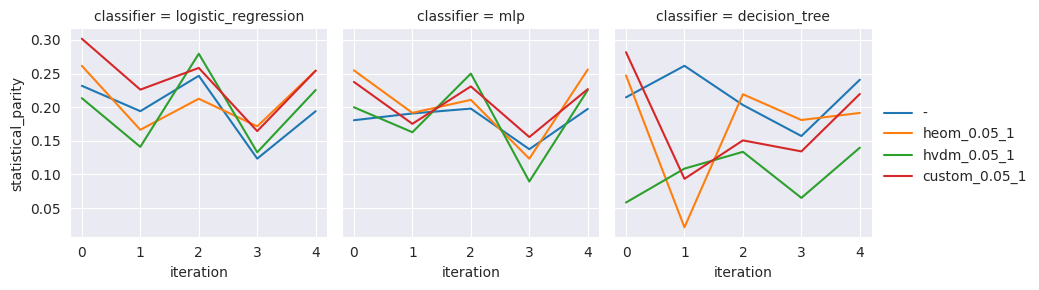

heart_disease


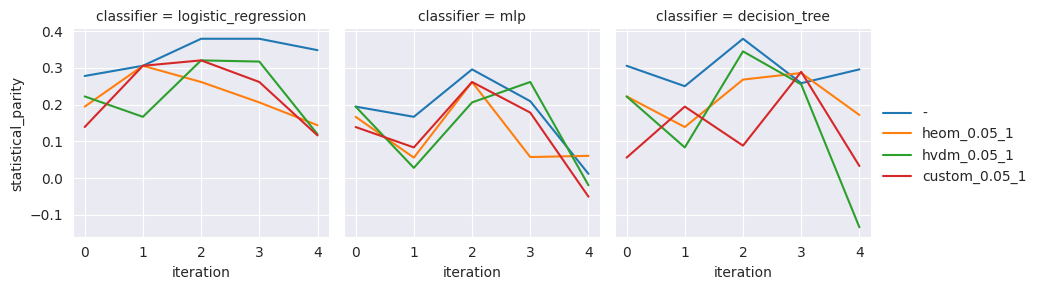

bank


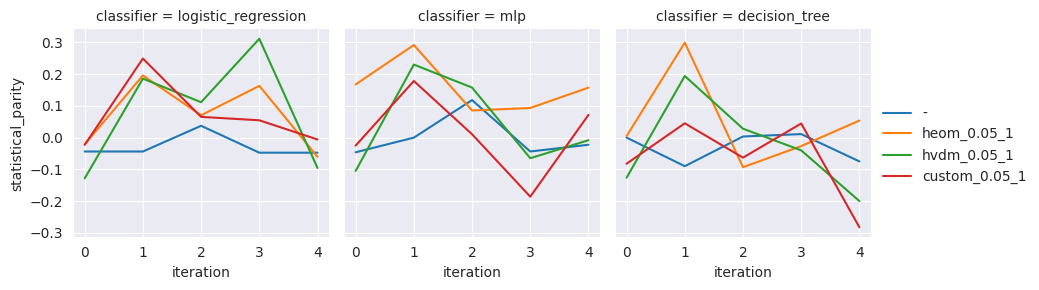

german


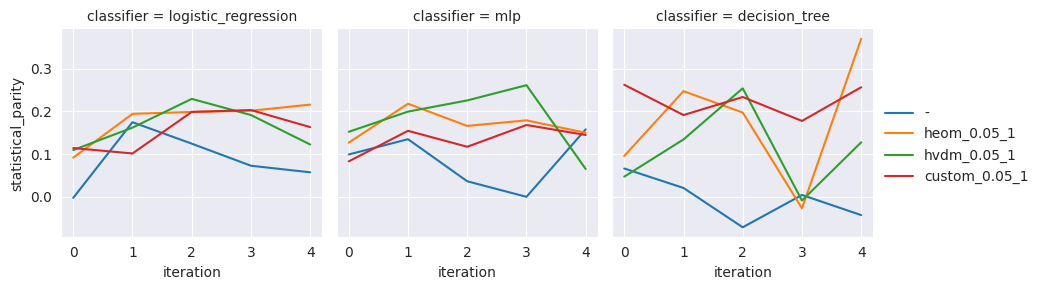

In [44]:
for dataset_name, dfs in zip(dataset_names, dfs_fairness):
    print(dataset_name)
    aggregate_runs_no_mean(dfs, y='statistical_parity')